In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from scipy import sparse
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from scipy.special import softmax
from plots import plot_learning_curves, plot_confusion_matrix
from utils import train_RNN, evaluate, VisitSequenceWithLabelDataset, visit_collate_fn

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import average_precision_score as pr_auc
from model import RNN
from create_dataset import get_seqs_labels, calculate_num_features

%load_ext autoreload
%autoreload 2

# Get Data

In [2]:
file = open('data/train.pkl', 'rb')
train_df = pickle.load(file)
file = open('data/valid.pkl', 'rb')
valid_df = pickle.load(file)
file = open('data/test.pkl', 'rb')
test_df = pickle.load(file)

# Create sequence and labels for train, valid, and test set

In [3]:
train_seqs, train_labels = get_seqs_labels(train_df)
val_seqs, val_labels = get_seqs_labels(valid_df)
test_seqs, test_labels = get_seqs_labels(test_df)
num_features = calculate_num_features(train_seqs)

# Initialize model hyperparmaters

In [4]:
NUM_EPOCHS = 3
BATCH_SIZE = 128
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0
output_path = 'model_object/'

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
train_dataset = VisitSequenceWithLabelDataset(train_seqs, train_labels, num_features)
valid_dataset = VisitSequenceWithLabelDataset(val_seqs, val_labels, num_features)
test_dataset = VisitSequenceWithLabelDataset(test_seqs, test_labels, num_features)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)

/Users/jasonzeng/Documents/OMSCS/cse6250/project/CSE6250_Project/utils.py:204: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  seqs_tensor = torch.FloatTensor(seqs)


Epoch: [0][0/84]	Time 7.255 (7.255)	Data 1.350 (1.350)	Loss 0.6950 (0.6950)	Accuracy 38.281 (38.281)
Epoch: [0][10/84]	Time 6.734 (6.539)	Data 1.199 (1.163)	Loss 0.6495 (0.6280)	Accuracy 64.062 (66.335)
Epoch: [0][20/84]	Time 9.014 (6.898)	Data 1.548 (1.191)	Loss 0.5862 (0.6081)	Accuracy 72.656 (69.196)
Epoch: [0][30/84]	Time 5.158 (7.071)	Data 0.984 (1.289)	Loss 0.5522 (0.6019)	Accuracy 75.000 (69.733)
Epoch: [0][40/84]	Time 5.454 (6.929)	Data 1.061 (1.254)	Loss 0.5196 (0.5953)	Accuracy 76.562 (70.293)
Epoch: [0][50/84]	Time 4.843 (6.682)	Data 0.960 (1.212)	Loss 0.5769 (0.5886)	Accuracy 70.312 (70.450)
Epoch: [0][60/84]	Time 6.355 (6.521)	Data 1.203 (1.188)	Loss 0.5450 (0.5854)	Accuracy 72.656 (70.415)
Epoch: [0][70/84]	Time 4.669 (6.384)	Data 0.945 (1.166)	Loss 0.5776 (0.5817)	Accuracy 68.750 (70.577)
Epoch: [0][80/84]	Time 6.373 (6.312)	Data 0.892 (1.145)	Loss 0.6189 (0.5809)	Accuracy 65.625 (70.544)
Test: [0/22]	Time 0.984 (0.984)	Loss 0.5997 (0.5997)	Accuracy 71.094 (71.094)
Test:

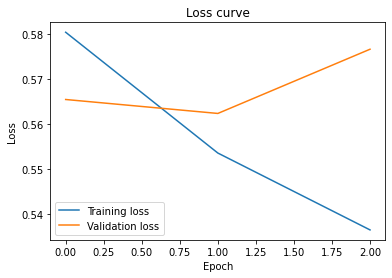

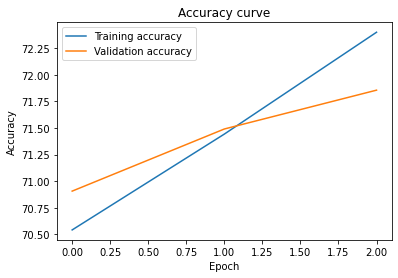

In [6]:
model = RNN(num_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies, train_aucs = [], [], []
valid_losses, valid_accuracies, valid_aucs = [], [], []
for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, train_auc = train_RNN(model, device, train_loader, criterion, optimizer, epoch)
    valid_loss, valid_accuracy, valid_auc, valid_results = evaluate(model, device, valid_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    
    train_aucs.append(train_auc)
    valid_aucs.append(valid_auc)

    is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
    if is_best:
        best_val_acc = valid_accuracy
        torch.save(model, os.path.join(output_path, "RNN.pth"), _use_new_zipfile_serialization=False)
plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, 'figures', 'rnn')

In [7]:
train_accuracies

[70.54125164299391, 71.44333772134162, 72.40180417071427]

In [8]:
train_aucs

[0.5052617267222786, 0.5312806833840517, 0.5693765958017415]

In [9]:
valid_accuracies

[70.90643274853801, 71.4912280255591, 71.85672519081517]

In [10]:
valid_aucs

[0.5008490064633058, 0.539541926242323, 0.555252957338534]

In [11]:
best_model = torch.load(os.path.join(output_path, "RNN.pth"))
# TODO: For your report, try to make plots similar to those in the previous task.

# TODO: You may use the validation set in case you cannot use the test set.
test_loss, test_accuracy, test_auc, test_results = evaluate(best_model, device, test_loader, criterion)

Test: [0/21]	Time 0.938 (0.938)	Loss 0.7766 (0.7766)	Accuracy 61.719 (61.719)
Test: [10/21]	Time 1.538 (1.227)	Loss 0.5431 (0.5993)	Accuracy 67.188 (70.170)
Test: [20/21]	Time 1.002 (1.216)	Loss 0.8013 (0.5933)	Accuracy 57.000 (70.752)


In [12]:
test_auc

0.5595246908468378

In [13]:
test_accuracy

70.75187969924812